In [100]:
def read_corpus_addnull(english_corpus= "corpus.en", foreign_corpus= "corpus.es"):
    '''
    read english and spanish corpus
    Input:
        eng: Str
        esp: str
    Return:
        english: list of sentences.split()
        foreign:
    '''
    english = [["*"] + e_sent.split() for e_sent in open(english_corpus)]
    foreign = [f_sent.split() for f_sent in open(foreign_corpus)]
    return english, foreign
english,foreign = read_corpus_addnull()


In [101]:
def read_corpus(english_corpus= "corpus.en", foreign_corpus= "corpus.es"):
    '''
    read english and spanish corpus
    Input:
        eng: Str
        esp: str
    Return:
        english: list of sentences.split()
        foreign: list of sentences.split()
    '''
    english = [e_sent.split() for e_sent in open(english_corpus)]
    foreign = [f_sent.split() for f_sent in open(foreign_corpus)]
    return english, foreign


## 1. IBM1

In [102]:
def IBM_model1(english_corpus, spanish_corpus, t_file_name = 'ibm1_t.pkl'):
    '''
    using training set to compute t parameters by ibm1 model 
    english_corpus= "corpus.en"
    spanish_corpus= "corpus.es"
    '''
    english, spanish = read_corpus_addnull(english_corpus, spanish_corpus)
    parallel_corpus = zip(english, spanish)
    from collections import defaultdict
    n_e = defaultdict(int)
    t = defaultdict(float)
    delta = defaultdict(int)
    wordpairs = set()
    for iteration in range(10):
        #if iteration ==1: break
        print("now processing {}th iteration".format(iteration))
        c_wordpair = defaultdict(int)
        c_e = defaultdict(int)

        if iteration == 0:
            for k, (e, s) in enumerate(parallel_corpus):
                
                for i,  s_i in enumerate(s):
                    for j , e_j in enumerate(e):
                        wordpair = (e_j, s_i)
                        if wordpair not in wordpairs:
                            wordpairs.add(wordpair)
                            n_e[e_j]+=1
        #Expectation
        parallel_corpus = zip(english, spanish)
        for k, (e, s) in enumerate(parallel_corpus):
            for i,  s_i in enumerate(s):
                i+=1
                tmp_sum = 0
                for j , e_j in enumerate(e):
                    if iteration ==0:
                        t[(s_i,e_j)] = 1/n_e[e_j]
                    tmp_sum += t[(s_i,e_j)]

                for j , e_j in enumerate(e):
                    delta[(k,i,j)] = t[(s_i,e_j)] / tmp_sum
                    c_wordpair[(e_j, s_i)] += delta[(k,i,j)]            
                    c_e[e_j] += delta[(k,i,j)]      
        print("finished {}th Expectation".format(iteration))
        #Maximization
        
        
    # Write t into pickle
        print("start writing t to {} th pickle file".format(iteration))
        import pickle
        t_file_name1 = 'ibm1_t{}.pkl'.format(iteration)
        f=open(t_file_name1,'wb') 
        pickle.dump(t , f)
        f.close()
        print("finished writing into pickle")
        
        print("finished {}th Maximization".format(iteration))
        
        for e, s in wordpairs:
            t[(s,e)] = c_wordpair[(e,s)] / c_e[e]
    

In [12]:
english_corpus= "corpus.en"
spanish_corpus= "corpus.es"
IBM_model1(english_corpus, spanish_corpus, 'ibm1_t.pkl')

now processing 0th iteration
finished 0th Expectation
start writing t to 0 th pickle file
finished writing into pickle
finished 0th Maximization
now processing 1th iteration
finished 1th Expectation
start writing t to 1 th pickle file
finished writing into pickle
finished 1th Maximization
now processing 2th iteration
finished 2th Expectation
start writing t to 2 th pickle file
finished writing into pickle
finished 2th Maximization
now processing 3th iteration
finished 3th Expectation
start writing t to 3 th pickle file
finished writing into pickle
finished 3th Maximization
now processing 4th iteration
finished 4th Expectation
start writing t to 4 th pickle file
finished writing into pickle
finished 4th Maximization
now processing 5th iteration
finished 5th Expectation
start writing t to 5 th pickle file
finished writing into pickle
finished 5th Maximization
now processing 6th iteration
finished 6th Expectation
start writing t to 6 th pickle file
finished writing into pickle
finished 6t

## Write into IBM1 prediciton file

In [103]:
def creat_prediction_file_ibm1(english_corpus_dev,spanish_corpus_dev,t,output_name):
    import numpy as np
    a=[]
    english_dev, spanish_dev = read_corpus_addnull(english_corpus_dev, spanish_corpus_dev)
    num_sentences = len(english_dev)
    
    file = open(output_name, "w")
    for idx in range(num_sentences) :
        for i, f in enumerate(spanish_dev[idx]) :
            list_t =[]
            for j, e in enumerate(english_dev[idx]) :
                list_t.append(t[f,e])
            #print("list_t: ",list_t)
            a_i = np.argmax(list_t)
            a.append(a_i)    
            file.write("{} {} {}\n".format(idx+1, a_i, i+1))
    print("finished writing to file")
    

In [14]:
import pickle
english_corpus_dev= "dev.en"
spanish_corpus_dev= "dev.es"
for iteration in range(10):
    filename = 'ibm1_t{}.pkl'.format(iteration)
    f=open(filename,'rb') 
    t= pickle.load(f)
    f.close()
    outname = 'dev_{}.out'.format(iteration)
    creat_prediction_file_ibm1(english_corpus_dev,spanish_corpus_dev,t,outname)

finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file


Text(0.5, 1.0, 'IBM1 F1-score changes by iteration')

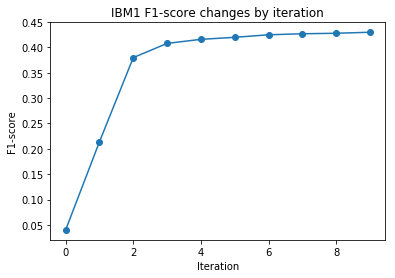

In [36]:
import matplotlib.pyplot as plt
x= list(range(10))
y= [0.040,0.214, 0.380,0.408, 0.416, 0.420, 0.425, 0.427, 0.428, 0.430]

plt.plot(x,y,"o-")
plt.xlabel("Iteration")
plt.ylabel("F1-score")
plt.title("IBM1 F1-score changes by iteration")
#for a,b in zip(x[::2], y[::2]): 
 #   plt.text(a, b, str(b))

## IBM Model 2

In [104]:
def IBM_model2(english_corpus, spanish_corpus, ibm1_t_name = 'ibm1_t.pkl', t_file_name = 'ibm2_t.pkl', q_file_name = 'ibm2_q.pkl'):
    import pickle
    english, spanish = read_corpus_addnull(english_corpus, spanish_corpus)
    parallel_corpus = list(zip(english, spanish))
    from collections import defaultdict
    n_e = defaultdict(int)
    t = defaultdict(float)
    q = defaultdict(float)
    delta = defaultdict(int)
    wordpairs = set()
    f=open(ibm1_t_name , 'rb') 
    t_ibm1= pickle.load(f)
    f.close()
    t = t_ibm1
    for iteration in range(5):
        #if iteration ==1: break
        print("now processing {}th iteration".format(iteration))
        c_wordpair = defaultdict(int)
        c_e = defaultdict(int)
        c_tri = defaultdict(int)
        c_qua = defaultdict(int)

        if iteration == 0:
            for k, (e, s) in enumerate(parallel_corpus):
                for i,  s_i in enumerate(s):
                    for j , e_j in enumerate(e):
                        wordpair = (e_j, s_i)
                        if wordpair not in wordpairs:
                            wordpairs.add(wordpair)

        #Expectation
        #parallel_corpus = zip(english, spanish)
        for k, (e, s) in enumerate(parallel_corpus):
            m = len(s)
            l = len(e)
            l= l-1
            for i,  s_i in enumerate(s):
                i+=1
                tmp_sum = 0
                for j , e_j in enumerate(e):
                    if iteration ==0:
                        #t[(s_i,e_j)] =t_ibm1[(s_i,e_j)]
                        q[(j,i,l,m)] = 1/(l+1)
                    tmp_sum += q[(j,i,l,m)] * t[(s_i,e_j)]

                for j , e_j in enumerate(e):
                    delta[(k,i,j)] = q[(j,i,l,m)] *t[(s_i,e_j)] / tmp_sum
                    c_wordpair[(e_j, s_i)] += delta[(k,i,j)]            
                    c_e[e_j] += delta[(k,i,j)]      
                    c_qua[(j,i,l,m)] = c_qua[(j,i,l,m)] + delta[(k,i,j)] 
                    c_tri[(i,l,m)] = c_tri[(i,l,m)] + delta[(k,i,j)] 
                    
        print("finished {}th Expectation".format(iteration))
        #Maximization

        

        print("finished {}th Maximization".format(iteration))
    # Write t into pickle
        print("start writing t to pickle file")
        t_file_name = 'ibm2_t{}.pkl'.format(iteration)
        f=open(t_file_name,'wb') 
        pickle.dump(t , f)
        f.close()
        q_file_name = 'ibm2_q{}.pkl'.format(iteration)
        f=open(q_file_name,'wb') 
        pickle.dump(q , f)
        f.close()
        print("finished writing to pickle file")
        
        #Update t parameter
        for e, s in wordpairs:
            t[(s,e)] = c_wordpair[(e,s)] / c_e[e]

        #Update q parameter
        for k, (e, s) in enumerate(parallel_corpus):
            m = len(s)
            l = len(e)
            l=l-1
            for i,  s_i in enumerate(s):
                i+=1
                for j , e_j in enumerate(e):
                    q[(j,i,l,m)] = c_qua[(j,i,l,m)] / c_tri[(i,l,m)]

In [30]:
english_corpus= "corpus.en"
spanish_corpus= "corpus.es"
#for iteration in range(10):
 #   ibm1_t_name = 'ibm1_t.pkl'.format(iteration)
    
IBM_model2(english_corpus, spanish_corpus, ibm1_t_name = 'ibm1_t.pkl', t_file_name = 'ibm2_t.pkl', q_file_name = 'ibm2_q.pkl')


now processing 0th iteration
finished 0th Expectation
finished 0th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 1th iteration
finished 1th Expectation
finished 1th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 2th iteration
finished 2th Expectation
finished 2th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 3th iteration
finished 3th Expectation
finished 3th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 4th iteration
finished 4th Expectation
finished 4th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 5th iteration
finished 5th Expectation
finished 5th Maximization
start writing t to pickle file
finished writing to pickle file
now processing 6th iteration
finished 6th Expectation
finished 6th Maximization
start writing t to pickle file
finished writing to pickle file

In [105]:
def creat_prediction_file_ibm2(english_corpus_dev, spanish_corpus_dev, t, q, outfile):
    import numpy as np
    a=[]
    english_dev, spanish_dev = read_corpus_addnull(english_corpus_dev, spanish_corpus_dev)
    num_sentences = len(english_dev)
    
    #file = open("dev2.out", "w")
    file = open(outfile, "w")
    for idx in range(num_sentences) :
        m = len(spanish_dev[idx])
        l = len(english_dev[idx])
        l=l-1
        for i, f in enumerate(spanish_dev[idx]) :
            i+=1
            list_t =[]
            for j, e in enumerate(english_dev[idx]) :
                list_t.append(q[(j,i,l,m)] * t[(f,e)])
            a_i = np.argmax(list_t)
            a.append(a_i)
            file.write("{} {} {}\n".format(idx+1, a_i, i))
    print("finished writing to file")

In [32]:
import pickle
english_corpus_dev= "dev.en"
spanish_corpus_dev= "dev.es"
for iteration in range(10):
    t_file_name = 'ibm2_t{}.pkl'.format(iteration)
    f=open(t_file_name,'rb') 
    t_ibm2 = pickle.load(f)
    f.close()
    q_file_name = 'ibm2_q{}.pkl'.format(iteration)
    f = open(q_file_name,'rb') 
    q_ibm2 = pickle.load(f)
    f.close()
    outfile = "dev2_{}.out".format(iteration)
    creat_prediction_file_ibm2(english_corpus_dev,spanish_corpus_dev,t_ibm2,q_ibm2, outfile)

finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file
finished writing to file


Text(0.5, 1.0, 'IBM2 F1-score changes by iteration')

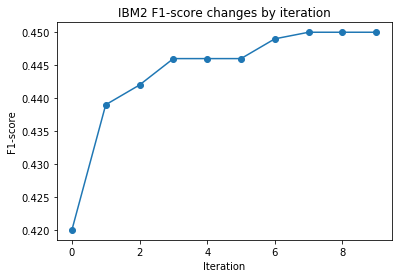

In [35]:
import matplotlib.pyplot as plt
x= list(range(10))
y= [0.42,0.439,0.442, 0.446, 0.446, 0.446, 0.449,0.450,0.450,0.45]

plt.plot(x,y,"o-")
plt.xlabel("Iteration")
plt.ylabel("F1-score")
plt.title("IBM2 F1-score changes by iteration")

### PART 3

### Alignment from p(f|e) Model:

In [106]:
def obtain_fe_align(eng_sentence , for_sentence, t, q):

    import numpy as np
    l = len(eng_sentence)
    m = len(for_sentence)
    coor = []
    a=[]
    l=l-1
    result_fe = np.full((l,m), False, dtype=bool)
    for i, f in enumerate(for_sentence) :
        i+=1
        list_t =[]
        for j, e in enumerate(eng_sentence) :
            list_t.append(q[(j,i,l,m)] * t[(f,e)])
        a_i = np.argmax(list_t)
        coor.append((a_i,i))
        result_fe[a_i-1, i-1 ] = True
        a.append(a_i)
    #print("shape of result_fe : ", result_fe.shape)
    return result_fe
#result_fe =  obtain_fe_align(eng_sentence, for_sentence)
    

### Obtain t, q parameters from IBM1 and IBM2

In [107]:
english_corpus= "corpus.es"
spanish_corpus= "corpus.en"
IBM_model1(english_corpus, spanish_corpus, t_file_name = 'ibm1_t_reverse.pkl')
IBM_model2(english_corpus, spanish_corpus, ibm1_t_name = 'ibm1_t_reverse.pkl', t_file_name = 'ibm2_t_reverse.pkl', q_file_name = 'ibm2_q_reverse.pkl')

now processing 0th iteration
finished 0th Expectation
start writing t to 0 th pickle file
finished writing into pickle
finished 0th Maximization
now processing 1th iteration
finished 1th Expectation
start writing t to 1 th pickle file
finished writing into pickle
finished 1th Maximization
now processing 2th iteration
finished 2th Expectation
start writing t to 2 th pickle file
finished writing into pickle
finished 2th Maximization
now processing 3th iteration
finished 3th Expectation
start writing t to 3 th pickle file
finished writing into pickle
finished 3th Maximization
now processing 4th iteration
finished 4th Expectation
start writing t to 4 th pickle file
finished writing into pickle
finished 4th Maximization
now processing 5th iteration
finished 5th Expectation
start writing t to 5 th pickle file
finished writing into pickle
finished 5th Maximization
now processing 6th iteration
finished 6th Expectation
start writing t to 6 th pickle file
finished writing into pickle
finished 6t

KeyboardInterrupt: 

### Alignment from p(e|f) Model:

In [23]:

def obtain_ef_align(eng_sentence , for_sentence , t ,q):

    import numpy as np
    #print(eng_sentence)
    #print(for_sentence)

    l = len(for_sentence)
    m = len(eng_sentence)
    coor = []
    a=[]
    l=l-1
    result_ef = np.full((m,l), False, dtype=bool)
    for i, f in enumerate(eng_sentence) :
        i+=1
        list_t =[]
        for j, e in enumerate(for_sentence) :
            list_t.append(q[(j,i,l,m)] * t[(f,e)])
        a_i = np.argmax(list_t)
        coor.append((a_i,i))
        result_ef[i-1, a_i-1 ] = True
        a.append(a_i)

    #print("shape of result_ef : ", result_ef.shape)
    return result_ef

def get_align_matrix(result_ef, result_fe):
    l, m = result_ef.shape
    result_intersect = result_ef * result_fe
    result_union = result_ef | result_fe
    result = result_intersect
    idx_inter = np.where(result_intersect == True)
    for i , j in zip(idx_inter[0], idx_inter[1]):
        for ii in range(i-1, i+2):
            for jj in range(j -1, j+2):
                if ii>=0 and ii<l and jj>=0 and jj<m:
                    if  result_union[ii,jj] ==True:
                        result[ii,jj] = True
    #for i in range(l):
    #   if any(result[i,:]) == False:
    #      result[i,:] = result_union[i,:]
            
    return result


### Growing Alignments

In [24]:

##   p(f|e) model

def creat_prediction_file_heuristics(english_corpus_dev= "dev.en", spanish_corpus_dev = "dev.es"):
    import numpy as np
    import pickle
    english_dev, spanish_dev = read_corpus_addnull(english_corpus_dev, spanish_corpus_dev )
    spanish_dev_reverse, english_dev_reverse = read_corpus_addnull(spanish_corpus_dev, english_corpus_dev)
    
    # Load t, q
    f=open('ibm2_t.pkl','rb') 
    t= pickle.load(f)
    f.close()
    f=open('ibm2_q.pkl','rb') 
    q= pickle.load(f)
    f.close()
    
    # Load t_reverse, q_reverse
    f=open('ibm2_t_reverse.pkl','rb') 
    t_reverse= pickle.load(f)
    f.close()
    f=open('ibm2_q_reverse.pkl','rb') 
    q_reverse= pickle.load(f)
    f.close()
    print("t and q parameters loaded")
    predict_result_array=[]
    num_sentences = len(english_dev)
    file = open("dev3.out", "w")
    for idx in range(num_sentences) :
        print("processing {}th sentence".format(idx+1))
        eng_sentence = english_dev[idx]
        for_sentence = spanish_dev[idx]
        eng_sentence_reverse = english_dev_reverse[idx]
        for_sentence_reverse = spanish_dev_reverse[idx]
        result_fe = obtain_fe_align(eng_sentence , for_sentence, t, q)
        result_ef = obtain_ef_align(eng_sentence_reverse , for_sentence_reverse, t_reverse, q_reverse)
        result = get_align_matrix(result_ef, result_fe)
        predict_result_array.append(result)
        aligns = np.where(result ==True)
        for i, j in zip(aligns[0], aligns[1]):
            file.write("{} {} {}\n".format(idx+1, i+1 , j+1))
    file.close()
    print("finished writing to file")
    return predict_result_array





In [25]:
predict_result_array = creat_prediction_file_heuristics()

t and q parameters loaded
processing 1th sentence
processing 2th sentence
processing 3th sentence
processing 4th sentence
processing 5th sentence
processing 6th sentence
processing 7th sentence
processing 8th sentence
processing 9th sentence
processing 10th sentence
processing 11th sentence
processing 12th sentence
processing 13th sentence
processing 14th sentence
processing 15th sentence
processing 16th sentence
processing 17th sentence
processing 18th sentence
processing 19th sentence
processing 20th sentence
processing 21th sentence
processing 22th sentence
processing 23th sentence
processing 24th sentence
processing 25th sentence
processing 26th sentence
processing 27th sentence
processing 28th sentence
processing 29th sentence
processing 30th sentence
processing 31th sentence
processing 32th sentence
processing 33th sentence
processing 34th sentence
processing 35th sentence
processing 36th sentence
processing 37th sentence
processing 38th sentence
processing 39th sentence
processi

In [73]:
result_intersect = result_ef * result_fe
result_union = result_ef | result_fe
result = result_intersect
print("result f e")
print(result_fe)
print("result e f")
print(result_ef)

print("result intersection")
print(result_intersect)
print("result union")
print(result_union)


print("_______________")
idx_inter = np.where(result_intersect == True)

for i , j in zip(idx_inter[0], idx_inter[1]):
    for ii in range(i-1, i+2):
        for jj in range(j -1, j+2):
            if ii>=0 and ii<m and jj>=0 and jj<l:
                if  result_union[ii,jj] ==True:
                    result[ii,jj] = True

print(result)


result f e
[[False  True  True False False False False]
 [False False False  True False False False]
 [ True False False False  True  True False]
 [False False False False False False  True]]
result e f
[[False False False False False  True False]
 [False False False  True False False False]
 [False False False False False  True False]
 [False False False False False False  True]]
result intersection
[[False False False False False False False]
 [False False False  True False False False]
 [False False False False False  True False]
 [False False False False False False  True]]
result union
[[False  True  True False False  True False]
 [False False False  True False False False]
 [ True False False False  True  True False]
 [False False False False False False  True]]
_______________
[[False False  True False False False False]
 [False False False  True False False False]
 [False False False False  True  True False]
 [False False False False False False  True]]


### Construct correct result array

In [29]:
import numpy as np
import pickle
f = open('dev2.out','r')
english, spanish= read_corpus(english_corpus = "dev.en", foreign_corpus = "dev.es")
print(len(english))

g=f.readlines()
f.close()
correct_result = []
idxs =[]
eng_idx = []
for_idx = []
idx_pre =1
print(len(g))
print(g[-1])
#print(len(gg))
ii = 0
idx_sub =[int(k) for k in  g[0].split()]
for idx in range(len(english)):
    #print("in the loop")
    #print( idx_sub[0])
    #print((idx+1))
    while idx_sub[0] == (idx+1):
        #print("in the loop")
        #print(i)
        eng_idx.append(idx_sub[1]-1)
        for_idx.append(idx_sub[2]-1)
        ii+=1
        if ii < len(g):
            idx_sub =[int(k) for k in g[ii].split()]
        else:
            idx_sub= [1,1,1]
    print()
    result_sep = np.full((len(english[idx]),len(spanish[idx])), False, dtype=bool)
    for i, j in zip(eng_idx, for_idx):
        #print(i,j)
        result_sep[i,j] = True
    correct_result.append(result_sep)

    eng_idx = []
    for_idx = []
    print("finished {}th sentence".format(idx+1))

f = open("predict_array_ibm2.pkl",'wb')
pickle.dump(correct_result, f)
f.close()


200
6112
200 45 50


finished 1th sentence

finished 2th sentence

finished 3th sentence

finished 4th sentence

finished 5th sentence

finished 6th sentence

finished 7th sentence

finished 8th sentence

finished 9th sentence

finished 10th sentence

finished 11th sentence

finished 12th sentence

finished 13th sentence

finished 14th sentence

finished 15th sentence

finished 16th sentence

finished 17th sentence

finished 18th sentence

finished 19th sentence

finished 20th sentence

finished 21th sentence

finished 22th sentence

finished 23th sentence

finished 24th sentence

finished 25th sentence

finished 26th sentence

finished 27th sentence

finished 28th sentence

finished 29th sentence

finished 30th sentence

finished 31th sentence

finished 32th sentence

finished 33th sentence

finished 34th sentence

finished 35th sentence

finished 36th sentence

finished 37th sentence

finished 38th sentence

finished 39th sentence

finished 40th sentence

finished 41th sentence

fini

In [113]:
idx =10
english, spanish= read_corpus(english_corpus= "dev.en", foreign_corpus= "dev.es")
print("english sentence length: ", len(english[idx]))
print("english sentence: ")
print(english[idx])
print("spanish sentence length: ", len(spanish[idx]))
print("spanish sentence: ")
print(spanish[idx])
print(np.sum(correct_result[idx]))
print(correct_result[idx].shape)
print(correct_result[idx])


english sentence length:  8
english sentence: 
['i', 'have', 'always', 'had', 'confidence', 'in', 'this', '.']
spanish sentence length:  5
spanish sentence: 
['siempre', 'he', 'tenido', 'confianza', '.']
5
(8, 5)
[[False  True False False False]
 [False False False False False]
 [ True False False False False]
 [False False  True False False]
 [False False False  True False]
 [False False False False False]
 [False False False False False]
 [False False False False  True]]


In [30]:
print(len(correct_result))
#print(predict_result_array)
f = open("predict_array_3.pkl",'rb')
array_3 = pickle.load( f)
f.close()

f = open("correct_array.pkl",'rb')
correct_array = pickle.load( f)
f.close()


f = open("predict_array_ibm2.pkl",'rb')
array_ibm2 = pickle.load(f)
f.close()


200


#### Example Analysis IBM2 

In [128]:
error_rate2 = []
error_no2 = []
for i in range(len(array_ibm2)):
    tmp =np.sum(array_ibm2[i] != correct_array[i])
    total = array_ibm2[i].size
    error_rate2.append(tmp/total)
    error_no2.append(tmp)

In [133]:
idx =36

print(english[idx])
print(spanish[idx])
print(len(english[idx]))
print(len(spanish[idx]))
print(correct_array[idx])
print(array_ibm2[idx])

print("error rate: ")
print(error_no2[idx])

#print("ibm2")
#print(array_ibm2[191])
print(np.where(correct_array[idx] != array_ibm2[idx] ))
print(np.argsort(error_no2)[-9:])
for idx in np.argsort(error_no2)[-8:]:
    print(error_no2[idx])

['mr', 'president', ',', 'i', 'voted', 'for', 'the', 'decourrière', 'report', 'on', 'the', 'community', 'initiative', 'interreg', ',', 'mainly', 'because', 'of', 'the', 'reply', 'commissioner', 'barnier', 'gave', 'to', 'some', 'members', 'who', 'took', 'the', 'floor', 'and', 'asked', 'for', 'this', 'programme', 'to', 'make', 'greater', 'reference', 'to', 'border', 'regions', 'with', 'maritime', 'frontiers', '.', 'i', 'voted', 'for', 'it', ',', 'not', 'just', 'because', 'i', 'was', 'born', 'in', 'a', 'coastal', 'town', ',', 'genoa', ',', 'but', 'above', 'all', 'because', 'the', 'frontiers', 'of', 'regions', 'bordered', 'by', 'the', 'sea', 'are', 'frontiers', 'too', '.']
['(', 'it', ')', 'señor', 'presidente', ',', 'he', 'votado', 'a', 'favor', 'del', 'informe', 'decourrière', 'sobre', 'la', 'iniciativa', 'comunitaria', 'interreg', ',', 'sobre', 'todo', 'por', 'la', 'respuesta', 'que', 'el', 'comisario', 'sr.', 'barnier', 'ha', 'dado', 'a', 'algunos', 'diputados', 'que', 'han', 'interven

### Example Analysis part3

In [126]:
error_rate3 = []
error_no3 = []
for i in range(len(array_3)):
    tmp =np.sum(array_3[i] != correct_array[i])
    total = array_3[i].size
    error_rate3.append(tmp/total)
    error_no3.append(tmp)

In [153]:
short_sent_idx=[]
for i,e in enumerate(english):
    if len(e) < 12:
        short_sent_idx.append(i)
print("short sents: ",short_sent_idx)

idx = 10


for i in short_sent_idx:
    #print("idx: {}, error_rate_3: {}, error_rate_2:{}   ".format( i, error_rate3[i], error_rate2[i]) )
    if error_rate2[i]< error_rate3[i]:
        print("this idx has larger error in heuristic", i)
    for j in range(array_3[i].shape[1]):
        if np.sum(array_3[i][:,j])>2:
            print("one-to-many: ", i)
            break

print(english[idx])
print(spanish[idx])
print(len(english[idx]))
print(len(spanish[idx]))
print(correct_array[idx])
print(array_3[idx])

print("error rate_3: ")
print(error_rate3[idx])
print("error rate_2: ")
print(error_rate2[idx])

#print("ibm2")
#print(array_ibm2[191])
print(np.where(correct_array[idx] != array_3[idx] ))
print(np.argsort(error_rate3))
for idx in np.argsort(error_rate3)[:8]:
    print(error_rate3[idx])

short sents:  [6, 8, 10, 14, 32, 34, 37, 45, 55, 58, 62, 77, 81, 105, 130, 139, 148, 156, 162, 170, 171, 180, 195, 196]
this idx has larger error in heuristic 10
one-to-many:  34
one-to-many:  77
this idx has larger error in heuristic 81
one-to-many:  81
this idx has larger error in heuristic 148
one-to-many:  162
one-to-many:  170
one-to-many:  171
['i', 'have', 'always', 'had', 'confidence', 'in', 'this', '.']
['siempre', 'he', 'tenido', 'confianza', '.']
8
5
[[False False False False False]
 [False  True False False False]
 [ True False False False False]
 [False False  True False False]
 [False False False  True False]
 [False False False False False]
 [False False False False False]
 [False False False False  True]]
[[False  True False False False]
 [False  True False False False]
 [ True False False False False]
 [False False  True False False]
 [False False False  True False]
 [False False  True False False]
 [False False False  True False]
 [False False False False  True]]
erro